<a href="https://colab.research.google.com/github/naveen-ramavath/machine-learning/blob/main/assaignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

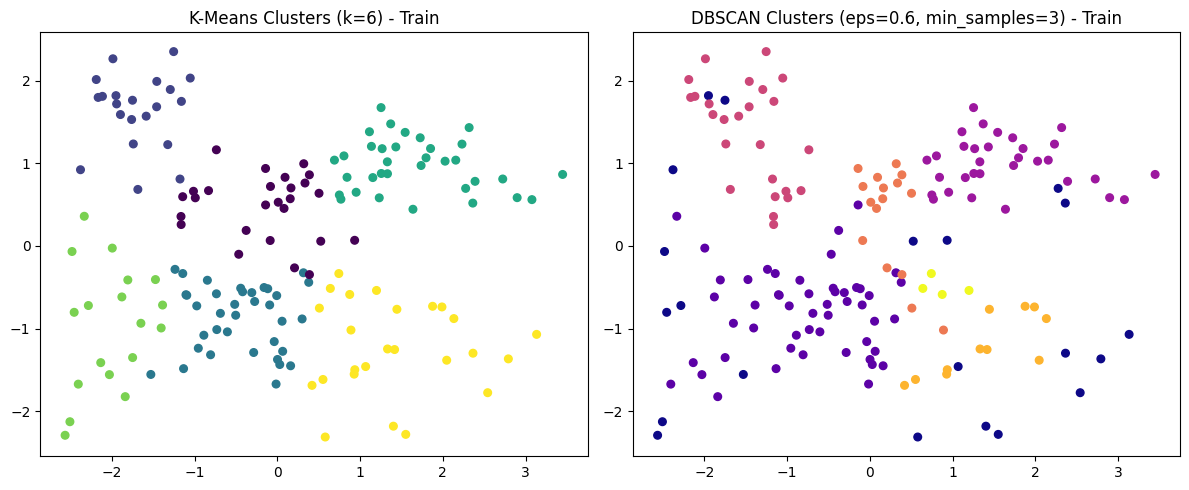

✅ RESULTS SUMMARY
Best K for K-Means: 6
Best Silhouette (K-Means - Train): 0.437
Best DBSCAN Params: (np.float64(0.6), 3)
Best Silhouette (DBSCAN - Train): 0.2881404970352769


In [5]:
# -------------------- IMPORTS -------------------- #
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestCentroid

# -------------------- LOAD DATASET -------------------- #
df = pd.read_csv("Mall_Customers.csv")

# -------------------- PREPROCESSING -------------------- #
# Detect Gender column dynamically
gender_col = None
for col in df.columns:
    if "gender" in col.lower():
        gender_col = col
        break

# Encode gender column
if gender_col:
    le = LabelEncoder()
    df[gender_col] = le.fit_transform(df[gender_col])

# Use numeric features only (exclude ID)
feature_cols = [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]
X = df[feature_cols]


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------- TRAIN-TEST SPLIT -------------------- #
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# -------------------- K-MEANS CLUSTERING -------------------- #
k_values = range(2, 9)
best_silhouette = -1
best_k = None
best_kmeans = None

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_train)
    sil = silhouette_score(X_train, labels)
    if sil > best_silhouette:
        best_silhouette = sil
        best_k = k
        best_kmeans = kmeans

kmeans_train_labels = best_kmeans.predict(X_train)
kmeans_test_labels = best_kmeans.predict(X_test)

# -------------------- DBSCAN CLUSTERING -------------------- #
eps_values = np.arange(0.3, 3.1, 0.3)
min_samples_values = [2, 3, 5, 8, 10]

best_sil = -1
best_params = None
best_dbscan_labels_train = None
best_dbscan_labels_test = None

for eps in eps_values:
    for ms in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels_train = dbscan.fit_predict(X_train)
        # Ignore noise points (-1) for silhouette
        unique_labels = set(labels_train) - {-1}
        if len(unique_labels) > 1:
            sil = silhouette_score(X_train, labels_train)
            if sil > best_sil:
                best_sil = sil
                best_params = (eps, ms)
                best_dbscan_labels_train = labels_train
                # Approximate test labels using NearestCentroid
                clf = NearestCentroid()
                # Remove noise points for fitting
                mask = labels_train != -1
                clf.fit(X_train[mask], labels_train[mask])
                best_dbscan_labels_test = clf.predict(X_test)

# -------------------- PCA VISUALIZATION -------------------- #
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(12, 5))

# K-Means train plot
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_train_labels, cmap="viridis", s=30)
plt.title(f"K-Means Clusters (k={best_k}) - Train")

# DBSCAN train plot
plt.subplot(1, 2, 2)
if best_dbscan_labels_train is not None:
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=best_dbscan_labels_train, cmap="plasma", s=30)
    plt.title(f"DBSCAN Clusters (eps={best_params[0]}, min_samples={best_params[1]}) - Train")
else:
    plt.title("DBSCAN found no valid clusters")

plt.tight_layout()
plt.show()

# -------------------- RESULTS SUMMARY -------------------- #
print("✅ RESULTS SUMMARY")
print(f"Best K for K-Means: {best_k}")
print(f"Best Silhouette (K-Means - Train): {best_silhouette:.3f}")
print(f"Best DBSCAN Params: {best_params if best_params else 'N/A'}")
print(f"Best Silhouette (DBSCAN - Train): {best_sil if best_sil > 0 else 'No valid clusters'}")
